# Day4

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 손실함수

,params,score
0,"[-1.0, 1.0]",36.254900
1,"[1.0, 0.0]",1.018294
2,"[1.0032193455976284, -0.0635741662734181]",1.014164
3,"[-0.06357416627341769, 1.0032193455976282]",11.825624


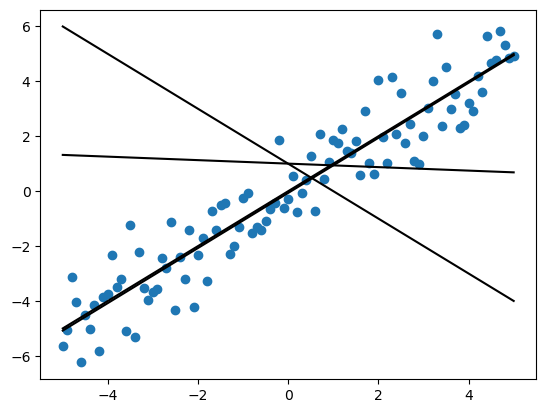

In [17]:
from sklearn.linear_model import LinearRegression


xs = np.linspace(-5, 5, 101)
noise = np.random.default_rng(seed=4).normal(0, 1, size=xs.shape)
ys = xs + noise

#선형모형
f = lambda x, w, b: w * x + b

params = []
params.append(np.array([-1.0, 1.])) # 초기값
params.append(np.array([1.0, 0.0])) # DGP

data = xs.reshape(-1, 1); target = ys
linreg = LinearRegression()
linreg.fit(data, target)
# 알고리즘 결과
params.append(np.array([linreg.coef_[0], linreg.intercept_]))
w, b = linreg.coef_, linreg.intercept_
assert np.allclose(f(xs, linreg.coef_[0], linreg.intercept_), linreg.predict(data))

# 정규 방정식
X = np.vstack([np.ones(xs.size), xs]).T # 디자인 행렬
최적해 = np.linalg.inv(X.T @ X) @ X.T @ ys # 정규 방정식의 해 (X^T X)^-1 X^T y
params.append(최적해)
assert np.allclose(최적해, np.append(b, w))


평균제곱오차 = lambda y_true, y_pred : np.mean((y_true - y_pred) ** 2)
scores = []

for w, b in params:
    y_pred = f(xs, w, b)
    score = 평균제곱오차(ys, y_pred)
    scores.append(score)

display(pd.DataFrame(zip(params, scores), columns=['params', 'score']))

plt.scatter(xs, ys)
for w, b in params:
    plt.plot(xs, f(xs, w, b), 'k')
plt.show()


In [18]:
class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = np.random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화
    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
     

class 신경망:
    def __init__(self):
        self.layers = []
    def add(self, layer):
        self.layers.append(layer)
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # 
        return x        

## MNIST

In [19]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True) # ~/의 의미 : 홈 디렉토리 (바인드 되어 있는 이 컴퓨터 디렉토리가 아님.)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

print(mnist['train'].data.shape, mnist['test'].data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [20]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    X = images.reshape(-1, 28*28).astype(np.float32) / 255.0    
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)

print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(test_data.max(), 1.0)



(60000, 784) (10000, 784)


In [21]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def softmax(x):
    # overflow 문제 해결
    x_max = np.max(x, axis=1, keepdims=True)
    x_exp = np.exp(x - x_max)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

model = 신경망()
model.add(다중퍼셉트론(28*28, 50, 활성화=sigmoid))
model.add(다중퍼셉트론(50, 100, 활성화=sigmoid))
model.add(다중퍼셉트론(100, 10, 활성화=softmax))

outputs = model(test_data)
print(outputs.shape)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

display(pd.DataFrame(outputs).assign(pred=y_pred, target=test_target)[:5].round(3))


(10000, 10)
정확도: 8.20%


,0,1,2,3,4,5,6,7,8,9,pred,target
0,0.0,0.000,0.000,0.000,0.0,0.001,0.096,0.000,0.746,0.157,8,7
1,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.999,0.001,8,2
2,0.0,0.002,0.002,0.000,0.0,0.074,0.002,0.000,0.088,0.831,9,1
3,0.0,0.000,0.000,0.000,0.0,0.004,0.038,0.000,0.241,0.716,9,0
4,0.0,0.001,0.000,0.001,0.0,0.011,0.283,0.001,0.640,0.063,8,4


## 원-핫 인코딩

다주 분류 출력은 확률 분포 형식이기 때문에 오차의 측정을 위해 정답 라벨을 확률 분포 형식으르 변환하여 비교해야 한다. 

변환하는 방식은 One Hot Encoding으로 달성할 수 있다. 

In [22]:
유형수 = len(np.unique(train_target))
원핫행렬 = np.eye(유형수)
pd.DataFrame(원핫행렬.astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


In [23]:
pd.DataFrame(원핫행렬[test_target]).assign(label = test_target).head()

,0,1,2,3,4,5,6,7,8,9,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


분류 출력은 정답과 확률 분포의 차이를 오차로서 측정

In [24]:
outputs = model(test_data)

pd.DataFrame({
    'pred': outputs[0].round(3),    
    'one-hot': 원핫행렬[test_target][0],
    'error': np.abs(outputs[0] - 원핫행렬[test_target][0])
}).T.round(3)

,0,1,2,3,4,5,6,7,8,9
pred,0.0,0.0,0.0,0.0,0.0,0.001,0.096,0.0,0.746,0.157
one-hot,0.0,0.0,0.0,0.0,0.0,0.000,0.000,1.0,0.000,0.000
error,0.0,0.0,0.0,0.0,0.0,0.001,0.096,1.0,0.746,0.157


$$
L = \frac{1}{2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\text{여기서:} \\
y_i \text{ : 실제값(관측값)} \\
\hat{y}_i \text{ : 예측값} \\
n \text{ : 데이터 포인트 개수} \\
(y_i - \hat{y}_i) \text{ : 오차(residual)}
$$

In [25]:
error = outputs - 원핫행렬[test_target]
오차제곱합 = np.sum(error ** 2, axis=1)

pd.DataFrame(outputs).assign(sse=오차제곱합, true= test_target).head().round(3)

,0,1,2,3,4,5,6,7,8,9,sse,true
0,0.0,0.000,0.000,0.000,0.0,0.001,0.096,0.000,0.746,0.157,1.590,7
1,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.999,0.001,1.997,2
2,0.0,0.002,0.002,0.000,0.0,0.074,0.002,0.000,0.088,0.831,1.699,1
3,0.0,0.000,0.000,0.000,0.0,0.004,0.038,0.000,0.241,0.716,1.573,0
4,0.0,0.001,0.000,0.001,0.0,0.011,0.283,0.001,0.640,0.063,1.493,4


In [26]:
def 오차제곱합(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2, axis=1)

def 교차엔트로피(y_true, y_pred):
    delta = 1e-7
    return -np.sum(y_true * np.log(y_pred + delta), axis=1)

y_pred = np.argmax(outputs, axis=1)
pd.DataFrame(outputs).assign(
    sse=오차제곱합(원핫행렬[test_target], outputs),
    cee=교차엔트로피(원핫행렬[test_target], outputs),
    pred=y_pred,
    true=test_target
).head().round(3)


,0,1,2,3,4,5,6,7,8,9,sse,cee,pred,true
0,0.0,0.000,0.000,0.000,0.0,0.001,0.096,0.000,0.746,0.157,1.590,12.817,8,7
1,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.999,0.001,1.997,13.847,8,2
2,0.0,0.002,0.002,0.000,0.0,0.074,0.002,0.000,0.088,0.831,1.699,6.084,9,1
3,0.0,0.000,0.000,0.000,0.0,0.004,0.038,0.000,0.241,0.716,1.573,11.219,9,0
4,0.0,0.001,0.000,0.001,0.0,0.011,0.283,0.001,0.640,0.063,1.493,14.102,8,4


0.0 2.302585092994046


/tmp/ipykernel_78649/3216042067.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x), 'k')


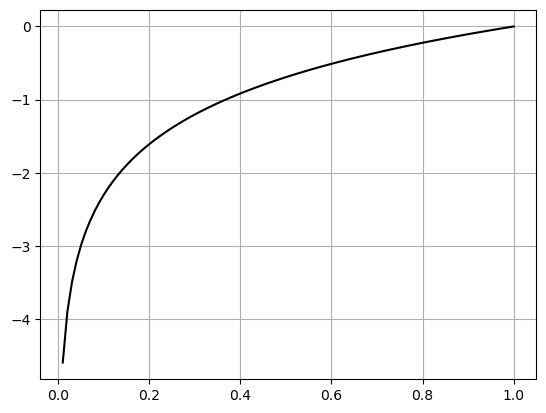

In [27]:
# loge 를 비분한 것의 그래프
x = np.linspace(0, 1, 100)

plt.plot(x, np.log(x), 'k')
plt.grid()

print(np.log(1), np.log(10))




## Day4 - 오후

In [28]:
엔트로피산출 = lambda 확률분포: -np.sum(확률분포 * np.log2(확률분포 + 1e-10), axis=1)

확률분포 = np.array([
    [0.5, 0.5],
    [0.3, 0.7],
    [0.1, 0.9],
    [0.01, 0.99]
])

display(pd.DataFrame(확률분포, columns=['P1', 'P2']).assign(엔트로피=엔트로피산출(확률분포)).round(3))

확률분포 = np.array([
    [1/4, 1/4, 1/4, 1/4],
    [1/2, 1/4, 1/8, 1/8],
    [1/8, 1/8, 1/4, 1/2],
    [1, 0, 0, 0]
])

pd.DataFrame(확률분포, columns=['P1', 'P2', 'P3', 'P4']).assign(엔트로피=엔트로피산출(확률분포)).round(3)



,P1,P2,엔트로피
0,0.50,0.50,1.000
1,0.30,0.70,0.881
2,0.10,0.90,0.469
3,0.01,0.99,0.081


,P1,P2,P3,P4,엔트로피
0,0.250,0.250,0.250,0.250,2.00
1,0.500,0.250,0.125,0.125,1.75
2,0.125,0.125,0.250,0.500,1.75
3,1.000,0.000,0.000,0.000,-0.00


## 교차 엔트로피

실제 확률 분포와 예상 확률 분포의 차이값

In [29]:
실제분포 = np.array([1.0, 0.0, 0.0])
라벨 = np.argmax(실제분포)
예상분포 = np.array([
    [1/3, 1/3, 1/3],
    [0.7, 0.2, 0.1],
    [0.99, 0.01, 0.0]])

pd.DataFrame(예상분포, columns=list('ABC')).assign(CEE=교차엔트로피(실제분포, 예상분포)).round(3)

,A,B,C,CEE
0,0.333,0.333,0.333,1.099
1,0.700,0.200,0.100,0.357
2,0.990,0.010,0.000,0.010


## 최적화

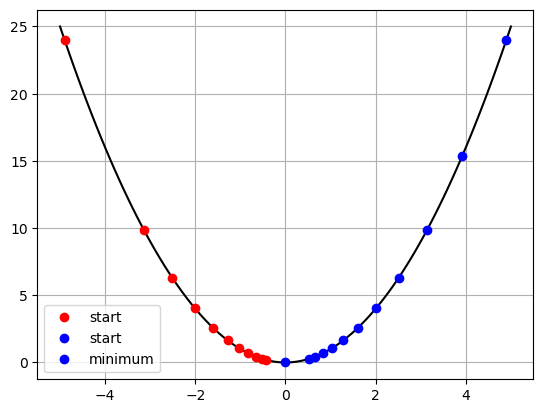

In [34]:
f = lambda x: x**2
dfdx = lambda x: 2*x # 도함수

def 수치미분(f, x, delta=1e-4):
    return (f(x+delta) - f(x-delta)) / (2*delta)

xs = np.linspace(-5, 5, 100)

plt.plot(xs, f(xs), 'k')
x = -4.9
plt.plot(x, f(x), 'ro', label='start')
# 경사하강
학습률 = 0.1
x -= dfdx(x) * 학습률
for _ in range(10):
    x -= dfdx(x) * 학습률
    plt.plot(x, f(x), 'ro')
x2 = 4.9
plt.plot(x2, f(x2), 'bo', label='start')
for _ in range(10):
    x2 -= 수치미분(f, x2) * 학습률
    plt.plot(x2, f(x2), 'bo')
plt.plot(0, f(0), 'bo', label='minimum')
plt.grid()
plt.legend()
plt.show()


## 신경망 학습 알고리즘

In [36]:
class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = np.random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화
    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
     

class 신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.손실함수 = 손실함수
    def add(self, layer):
        self.layers.append(layer)
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # 
        return x
    def fit(self, data, target, 학습횟수, 학습률):
        for epoch in range(학습횟수):
            # 1. 배치 데이터 선택
            X_batch = data
            y_batch = target            
            # 2. 경사 산출            
            f = lambda W: self.손실함수(X_batch, y_batch)
            for layer in self.layers:
                # 각 층의 가중치와 편향에 대한 손실함수의 기울기 계산
                dW = 수치미분(f, layer.W)
                db = 수치미분(f, layer.b)
                층별경사.append((dW, db))
            # 3. 매개변수 갱신 (경사 하강)
            for layer, (dW, db) in zip(self.layers, 층별경사):
                layer.W -= dW * 학습률
                layer.b -= db * 학습률
            

module/neuralnet.py

In [38]:
import numpy as np
import time

sigmoid = lambda z: 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - z.max()) # 오버플로 방지
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def 경사산출(f, x): # 편미분 형태
    h = 1e-4
    경사 = np.empty_like(x)
    
    for i, xi in enumerate(x):
        x[i] = xi + h
        fxh1 = f(x)
        x[i] = xi - h
        fxh2 = f(x)
        
        경사[i] = (fxh1 - fxh2) / (2 * h)
        x[i] = xi # 원래 값 복원

    return 경사

def 경사산출_2d(f, X): # 매개변수가 2차원 행렬인 경우
    경사 = np.zeros_like(X)
    
    for j, xj in enumerate(X):
        경사[j] = 경사산출(f, xj)
    return 경사

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(shape=(출력수,))
        self.활성화 = 활성화

    def __call__(self, X):
        Z = X @ self.W + self.b # 교재 식[3.9]
        if self.활성화 is not None:
            return self.활성화(Z)
        return Z

class 신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수
        
    def add(self, layer):
        self.layers.append(layer)
        
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def 손실산출(self, X, y):
        y_pred = self(X)
        손실 = self.loss_func(y, y_pred)
        return 손실
    
    def fit(self, X, y, 배치크기, 학습횟수, 학습률):
        """학습"""
        표본수 = X.shape[0]
        손실변화 = []
        for i in range(학습횟수):            
            print(f'학습 {i+1}/{학습횟수}')
            start_time = time.time()
            # 1. 미니배치
            배치색인 = np.random.choice(표본수, 배치크기)
            X_batch = X[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출        
            f = lambda 매개변수: self.손실산출(X_batch, y_batch)
            층별경사 = []
            for layer in self.layers:
                dW = 경사산출_2d(f, layer.W)
                db = 경사산출(f, layer.b)
                층별경사.append((dW, db))
            # 3. 매개변수 갱신 (경사 하강)
            for layer, (dW, db) in zip(self.layers, 층별경사):
                layer.W -= dW * 학습률
                layer.b -= db * 학습률
            end_time = time.time()
            # (선택적) 손실확인
            손실 = self.손실산출(X_batch, y_batch)
            손실변화.append(손실)
            print(f'\t손실: {손실:.3f}, \t시간: {end_time - start_time:.1f}초')
        return 손실변화

In [41]:
#MNIST

from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True) # ~/의 의미 : 홈 디렉토리 (바인드 되어 있는 이 컴퓨터 디렉토리가 아님.)
mnist['test'] = MNIST(root='~/data', train=False, download=True)


def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    X = images.reshape(-1, 28*28).astype(np.float32) / 255.0    
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)

In [48]:
model = 신경망(손실함수=교차엔트로피오차)
model.add(다중퍼셉트론(28*28, 50, 활성화=sigmoid))
model.add(다중퍼셉트론(50, 100, 활성화=sigmoid))
model.add(다중퍼셉트론(100, 10, 활성화=softmax))


원핫행렬 = np.eye(10)
손실변화 = model.fit(train_data, 원핫행렬[train_target], 배치크기=100, 학습횟수=4, 학습률=0.1)


학습 1/4
	손실: 7.921, 	시간: 33.5초
학습 2/4
	손실: 7.147, 	시간: 37.0초
학습 3/4
	손실: 7.611, 	시간: 38.2초
학습 4/4
	손실: 6.075, 	시간: 39.0초


In [46]:
outputs = model(test_data)

y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

pd.DataFrame({
    'pred': outputs[0].round(3),    
    'one-hot': 원핫행렬[test_target][0],
    'error': np.abs(outputs[0] - 원핫행렬[test_target][0])
}).T.round(3)

정확도: 14.13%


,0,1,2,3,4,5,6,7,8,9
pred,0.0,0.341,0.0,0.015,0.078,0.0,0.0,0.0,0.565,0.0
one-hot,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.000,0.0
error,0.0,0.341,0.0,0.015,0.078,0.0,0.0,1.0,0.565,0.0


## 1986 오차 역전파

In [64]:
class 더하기:
    def __call__(self, x, y):
        return x + y
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy
    
class 곱하기:
    def __init__(self):
        self.x = None
        self.y = None

    def __call__(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

class Inverse:
    def __init__(self):
        self.y = None
    
    def __call__(self, x): # backward 함수에서 사용할 값을 저장
        self.y = 1 / x
        return self.y
    
    def backward(self, dout):
        dx = dout * -self.y ** 2
        return dx

class Exp:
    def __init__(self):
        self.y = None
    
    def __call__(self, x):
        self.y = np.exp(x)
        return self.y

    def backward(self, dout):
        dx = dout * self.y
        return dx
    
    
합 = 더하기()
곱 = [곱하기() for _ in range(3)]

사과단가, 사과수량 = 100, 2
귤단가, 귤수량 = 150, 3
부가세 = 1.1 # 10%

print('# 순전파')
사과가격 = 곱[0](사과단가, 사과수량)
귤가격 = 곱[1](귤단가, 귤수량)
세전가격 = 합(사과가격, 귤가격)
세후가격 = 곱[2](세전가격, 부가세)
print(f'세전가격: {세전가격} x 부가세(10%) = 세후가격: {세후가격:.1f}')

print('# 역전파')
dx, dy = 곱[2].backward(1.0)
dx, dy = 합.backward(dx)
d귤단가, d귤수량 = 곱[1].backward(dx)
d사과단가, d사과수량 = 곱[0].backward(dx)

display(pd.DataFrame([{
    'd가격/d사과단가': d사과단가,
    'd가격/d사과수량': d사과수량,
    'd가격/d귤단가': d귤단가,
    'd가격/d귤수량': d귤수량
}], index=['역전파']).round(3))

# 순전파
세전가격: 650 x 부가세(10%) = 세후가격: 715.0
# 역전파


,d가격/d사과단가,d가격/d사과수량,d가격/d귤단가,d가격/d귤수량
역전파,2.2,110.0,3.3,165.0


In [ ]:
class Sigmoid:
    def __init__(self):
        self.add = 더하기()
        self.exp = Exp()
        self.inv = Inverse()
        self.mul = 곱하기()

    def __call__(self, x):
        x = self.mul(-1, x)
        x = self.exp(x)
        x = self.add(1, x)
        y = self.inv(x)
        return y

    def backward(self, dout):
        dx = self.inv.backward(dout)
        _, dx = self.add.backward(dx)
        dx = self.exp.backward(dx)
        _, dx = self.mul.backward(dx)        
        return dx

sigmoid = Sigmoid()
y = sigmoid(0.0)
print(f'sigmoid(0.0) = {y:.3f}')
dx = sigmoid.backward(1.0)
print(f'dx = {dx:.3f}')

assert np.isclose(dx, y*(1-y)) # 구현과 해석 결과가 같음을 확인
    
    

sigmoid(0.0) = 0.500
dx = 0.250


In [ ]:
import torch

사과단가 = torch.tensor(100.0, requires_grad=True)
사과수량 = torch.tensor(2.0, requires_grad=True)
귤단가 = torch.tensor(150.0, requires_grad=True)
귤수량 = torch.tensor(3.0, requires_grad=True)
부가세 = torch.tensor(1.1, requires_grad=True)

# 순전파 
사과가격 = 사과단가 * 사과수량
귤가격 = 귤단가 * 귤수량
세전가격 = 사과가격 + 귤가격
세후가격 = 세전가격 * 부가세

print(f'세전가격: {세전가격:.1f} x 부가세(10%) = 세후가격: {세후가격:.1f}')

# 역전파
세후가격.backward() # 역전파 시 모든 변수에 대한 기울기 계산

print(f'd가격/d사과단가: {사과단가.grad:.3f}')
print(f'd가격/d사과수량: {사과수량.grad:.3f}')
print(f'd가격/d귤단가: {귤단가.grad:.3f}')
print(f'd가격/d귤수량: {귤수량.grad:.3f}')
print(f'd가격/d부가세: {부가세.grad:.3f}')


세전가격: 650.0 x 부가세(10%) = 세후가격: 715.0
d가격/d사과단가: 2.200
d가격/d사과수량: 110.000
d가격/d귤단가: 3.300
d가격/d귤수량: 165.000
d가격/d부가세: 650.000
